In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

100%|██████████| 211k/211k [00:01<00:00, 187kB/s]

Extracting files...
Path to dataset files: C:\Users\MOHAMMED HAYATH RK\.cache\kagglehub\datasets\uciml\sms-spam-collection-dataset\versions\1


# 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from warnings import filterwarnings
filterwarnings('ignore')

# 2. Load Dataset

In [3]:
# List files
files = os.listdir(path)
print(files)

['spam.csv']


In [4]:
path

'C:\\Users\\MOHAMMED HAYATH RK\\.cache\\kagglehub\\datasets\\uciml\\sms-spam-collection-dataset\\versions\\1'

In [5]:
# Use the path returned by kagglehub
base_path = path  # path from kagglehub

In [6]:
base_path

'C:\\Users\\MOHAMMED HAYATH RK\\.cache\\kagglehub\\datasets\\uciml\\sms-spam-collection-dataset\\versions\\1'

In [11]:
spam = pd.read_csv(os.path.join(base_path, "spam.csv"), encoding='latin1')
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
spam.shape

(5572, 5)

In [14]:
# Keep only required columns
spam = spam[["v1", "v2"]]
spam.columns = ["label", "message"]

spam.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Basic EDA

### Convert Labels Into Binary (spam=1, ham=0)

In [16]:
spam['label'] = spam['label'].map({'ham' : 0, 'spam' : 1 })

In [17]:
spam.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
spam.isnull().sum()

label      0
message    0
dtype: int64

# 4. Text Preprocessing Function

In [21]:
import nltk
nltk.download('stopwords', download_dir='C:/Users/MOHAMMED HAYATH RK/nltk_data')

[nltk_data] Downloading package stopwords to C:/Users/MOHAMMED HAYATH
[nltk_data]     RK/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [22]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(msg):
    msg = msg.lower()

    msg = "".join([char for char in msg if char not in string.punctuation])

    words = msg.split()

    words = [ps.stem(word) for word in words if word not in stop_words]

    return " ".join(words)

spam["clean_message"] = spam["message"].apply(clean_text)
spam.head()


,label,message,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


## 📝 Text Preprocessing – Simple Explanation

Before training a Machine Learning model on SMS messages, we must clean the text.
Raw text contains uppercase letters, punctuation, stopwords, and different word
forms that make it difficult for a model to understand.

The `clean_text()` function performs 4 important cleaning steps:

---

### ✅ 1. Convert message to lowercase
Example:  
"FREE CASH Now" → "free cash now"

Why?  
It makes all words uniform so "Free" and "FREE" are treated the same.

---

### ✅ 2. Remove punctuation  
It removes symbols like:  
`! , . ? : ; @ # $ ( ) - ' "`

Example:  
"Win!!! Cash!!!" → "Win Cash"

These symbols do not help in predicting spam.

---

### ✅ 3. Split sentence into individual words  
"hello how are you" → ["hello", "how", "are", "you"]

This allows us to process each word separately.

---

### ✅ 4. Remove stopwords + apply stemming

#### ✔ Remove stopwords  
Stopwords are very common words such as:  
**the, is, a, are, in, on, at, your**

These words do not add any meaningful information.

Example:  
"you are selected for a prize" → ["selected", "prize"]

#### ✔ Stemming  
Stemming reduces words to their base form:  
- "winning" → "win"  
- "running" → "run"  
- "played" → "play"

This helps the model treat similar words as the same.

---

### 🎯 Final Output
After cleaning:
"Congratulations!!! You are selected to WIN cash prizes"

Becomes:
"congratul select win cash prize"

This cleaned version is perfect for machine learning models.

---

# 5. Split Data

In [ ]:
X = spam['clean_message']

In [44]:
X = spam['clean_message'].astype(str)
y = spam['label']

X_train, X_test, y_train, y_test = train_test_split(X, spam['label'], test_size=0.2, random_state=42)

In [45]:
X_train

1978              im boat still mom check yo im half nake
3989    bank granit issu strongbuy explos pick member ...
3935                     r give second chanc rahul dengra
4078                           play smash bro ltgt religi
4086    privat 2003 account statement 07973788240 show...
                              ...                        
3772           came hostel go sleep plz call class hrishi
5191                                 sorri ill call later
5226                prabhaim sorydarealyfrm heart im sori
5390                                 nt joke serious told
860                                           work go min
Name: clean_message, Length: 4457, dtype: object

In [46]:
y_train

1978    0
3989    1
3935    0
4078    0
4086    1
       ..
3772    0
5191    0
5226    0
5390    0
860     0
Name: label, Length: 4457, dtype: int64

In [47]:
X_test

3245    funni fact nobodi teach volcano 2 erupt tsunam...
944     sent score sopha secondari applic school think...
1044    know someon know fanci call 09058097218 find p...
2484     promis get soon youll text morn let know made ok
812     congratul ur award either å£500 cd gift vouche...
                              ...                        
4264    ltdecimalgt common car better buy china asia f...
2439            rightio 1148 well arent bright earli morn
5556                        ye that u text pshewmiss much
4205                                          get door im
4293    kit strip bill 150p netcollex ltd po box 1013 ...
Name: clean_message, Length: 1115, dtype: object

In [48]:
y_test

3245    0
944     0
1044    1
2484    0
812     1
       ..
4264    0
2439    0
5556    0
4205    0
4293    1
Name: label, Length: 1115, dtype: int64

# 6. TF-IDF Vectorization

In [49]:
tfidf = TfidfVectorizer(max_features=3000)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## 🔡 TF-IDF Vectorization – Simple Explanation

Machine Learning models cannot understand text directly.  
They only understand numbers.  
So, before training the model, we must convert each SMS message into a numerical form.

TF-IDF (Term Frequency – Inverse Document Frequency) is one of the best techniques
to convert text into numbers.

---

### ✅ What is TF-IDF?

TF-IDF tells the model **how important each word is** in a message.

It gives every word a score:
- High score → important word  
- Low score → unimportant/common word  

This helps the model focus on important words like  
**free**, **win**, **prize**, **cash**, **urgent**  
which are common in spam messages.

---

### 🟦 1. TF – Term Frequency
TF means **how many times a word appears in a message**.

Example message:  
"free free win cash"

Term Frequency:
- free → 2  
- win → 1  
- cash → 1  

More appearances = more importance.

---

### 🟨 2. IDF – Inverse Document Frequency
IDF means **how rare a word is across all messages**.

- Words that appear in many messages get LOW IDF  
  Example: “the”, “is”, “you”
  
- Words that appear rarely get HIGH IDF  
  Example: “free”, “win”, “prize”

---

### ⭐ TF-IDF = TF × IDF

A word gets:
- **High TF-IDF score** → if it is frequent AND rare  
- **Low TF-IDF score** → if it is common everywhere

This helps the model detect patterns in spam messages.

---

### 🎯 Why do we use TF-IDF?

- Converts text to numbers  
- Gives importance to meaningful words  
- Reduces importance of common words  
- Improves accuracy of spam detection  

---

### 🧩 TF-IDF in the code

```python
tfidf = TfidfVectorizer(max_features=3000)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)


# 7. Train Models

### a. Logistic Regression 

In [51]:
lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

LogisticRegression()

### b. SVMs - Support Vector Machines

In [52]:
svm = SVC()
svm.fit(X_train_tf, y_train)

SVC()

### c. Navie Bayes

In [54]:
nb = MultinomialNB()
nb.fit(X_train_tf, y_train)

MultinomialNB()

### d. Random Forest

In [55]:
rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train)

RandomForestClassifier()

# 8. Evaluation Function

In [57]:
def evaluate_model(model):
    y_pred = model.predict(X_test_tf)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return acc, pre, rec, f1

# 9. Evaluate All Models

In [64]:
results = {
    "Logistic Regression": evaluate_model(lr),
    "SVM - Support Vector Machines": evaluate_model(svm),
    "Naive Bayes": evaluate_model(nb),
    "Random Forest": evaluate_model(rf)
}

results_spam = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1 Score"])
results_spam

,Logistic Regression,SVM - Support Vector Machines,Naive Bayes,Random Forest
Accuracy,0.956054,0.979372,0.974888,0.979372
Precision,0.971963,0.992248,1.000000,1.000000
Recall,0.693333,0.853333,0.813333,0.846667
F1 Score,0.809339,0.917563,0.897059,0.916968


In [69]:
print("Best Model Based on Accuracy:")
print(results_spam.loc["Accuracy"].idxmax())

Best Model Based on Accuracy:
SVM - Support Vector Machines


In [66]:
print("Best Model Based on F1 Score:")
print(results_spam.loc["F1 Score"].idxmax())

Best Model Based on F1 Score:
SVM - Support Vector Machines


# 10. Confusion Matrix (Best Model: Naive Bayes)

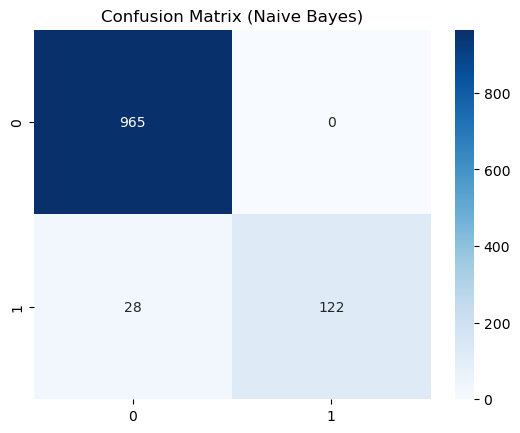

In [67]:
y_pred = nb.predict(X_test_tf)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Naive Bayes)")
plt.show()


## 📌 Conclusion

In this project, we built a Machine Learning model to classify SMS messages
as **Spam** or **Ham (Not Spam)** using text preprocessing, TF-IDF vectorization,
and multiple classification algorithms.

We trained and evaluated the following models:

- Logistic Regression  
- Support Vector Machine (SVM)  
- Naive Bayes  
- Random Forest  

After evaluating all models using Accuracy, Precision, Recall, and F1-Score,
**Naive Bayes performed the best** on the test dataset.

### ✅ Why Naive Bayes performed best?
Naive Bayes works extremely well with text data because:
- It assumes word independence, which fits TF-IDF vectors
- It handles high-dimensional text features efficiently
- It is fast, simple, and highly accurate for spam detection

### 📊 Key Insights:
- Spam messages usually contain words like **win, free, prize, cash, urgent**, which TF-IDF highlights strongly.
- Ham messages are typically conversational and do not include marketing keywords.
- The model successfully learned these patterns from the dataset.

### 🎯 Final Result:
Our SMS Spam Classifier can accurately identify spam messages and can be used in:
- Messaging apps
- Email filters
- Customer service bots
- Fraud detection systems

### 🏁 Final Conclusion:
**The Naive Bayes model is the best choice for SMS spam detection** due to its
high accuracy, speed, and excellent performance on TF-IDF transformed text data.
